DATA AUGMENTATION

**A. Target**
1. Move your last code's transformations to Albumentations. Apply ToTensor,     HorizontalFlip, Normalize (at min) + More (for additional points)
2. Please make sure that your test_transforms are simple and only using ToTensor and Normalize
3. Implement GradCam function as a module. 
4. Your final code (notebook file) must use imported functions to implement transformations and GradCam functionality
5. Target Accuracy is 87%

**B. Results**
1. Parameters: 11,173,962
2. Best Training Accuracy in 30 epochs: 96.51%
3. Best Test Accuracy in 30 epochs: 87.96 %
4. Total RF reached: 76*76 at the end of Conv block 4

**C. Analysis**

I have implemented Albumentations transforms for normalization ( by finding norm and std values for entire dataset ), Horizontal flip, Vertical flip, Rotations. This acts as a regularizer and now the model is not overfitting to the extent it was earlier

I have also implemented the grad cam functionality and results are displayed for few of the images


In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

import albumentations as A
from collections import Sequence
import numpy as np

from   torch.utils.data import Dataset
import torch.nn.functional as F

In [2]:
!git clone https://github.com/SachinDangayach/TSAI_EVA5.git 

fatal: destination path 'TSAI_EVA5' already exists and is not an empty directory.


In [3]:
from TSAI_EVA5.session9.dataset import session9_dataset as dataset
from TSAI_EVA5.session9.models import session8_resnet18_model as models
from TSAI_EVA5.session9.models import session8_train_model as train
from TSAI_EVA5.session9.models import session8_test_model as test
from TSAI_EVA5.session9.utils import session9_utils as utils
from TSAI_EVA5.session9.utils import session9_view_gradcam as grad_cam

## Extract, Load and Transform Data

In [4]:
# Calculate Ture Mean and STD
norm_mean,norm_std = dataset.cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Extract Datasets
train_set,test_set = dataset.get_datasets()
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Get train and test transform
train_transform, test_transform = dataset.get_album_transforms(norm_mean,norm_std)

In [7]:
# transform the data
train_set,test_set = dataset.trasnform_datasets(train_set, test_set, train_transform, test_transform)

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

CUDA Available? True


### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


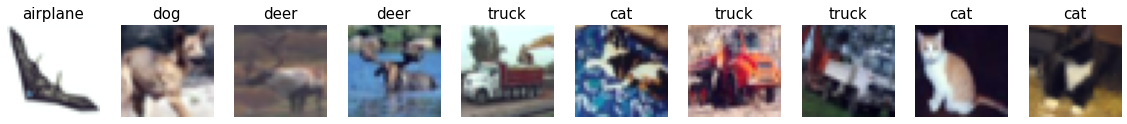

In [8]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Import Model and show model summary

In [9]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Train and Test Model

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.test(model, device, test_loader, test_losses, test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6011673212051392 Batch_id=390 Train Accuracy=31.85: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5361, Test Accuracy: 4121/10000 (41.21%)

EPOCH: 1


Loss=1.3702256679534912 Batch_id=390 Train Accuracy=47.86: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2843, Test Accuracy: 5250/10000 (52.50%)

EPOCH: 2


Loss=1.1729532480239868 Batch_id=390 Train Accuracy=56.27: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0421, Test Accuracy: 6275/10000 (62.75%)

EPOCH: 3


Loss=0.8248296976089478 Batch_id=390 Train Accuracy=63.03: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9688, Test Accuracy: 6575/10000 (65.75%)

EPOCH: 4


Loss=0.6631225347518921 Batch_id=390 Train Accuracy=67.83: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7890, Test Accuracy: 7233/10000 (72.33%)

EPOCH: 5


Loss=0.8414050936698914 Batch_id=390 Train Accuracy=71.19: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8131, Test Accuracy: 7175/10000 (71.75%)

EPOCH: 6


Loss=0.6788221597671509 Batch_id=390 Train Accuracy=74.08: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7642, Test Accuracy: 7339/10000 (73.39%)

EPOCH: 7


Loss=0.7559725642204285 Batch_id=390 Train Accuracy=76.20: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7323, Test Accuracy: 7450/10000 (74.50%)

EPOCH: 8


Loss=0.6719595193862915 Batch_id=390 Train Accuracy=78.60: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6841, Test Accuracy: 7690/10000 (76.90%)

EPOCH: 9


Loss=0.5284527540206909 Batch_id=390 Train Accuracy=80.15: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6207, Test Accuracy: 7922/10000 (79.22%)

EPOCH: 10


Loss=0.4470394551753998 Batch_id=390 Train Accuracy=82.04: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5403, Test Accuracy: 8154/10000 (81.54%)

EPOCH: 11


Loss=0.4609851837158203 Batch_id=390 Train Accuracy=83.61: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5369, Test Accuracy: 8119/10000 (81.19%)

EPOCH: 12


Loss=0.6222630143165588 Batch_id=390 Train Accuracy=85.00: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5182, Test Accuracy: 8297/10000 (82.97%)

EPOCH: 13


Loss=0.5898663401603699 Batch_id=390 Train Accuracy=85.83: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5492, Test Accuracy: 8227/10000 (82.27%)

EPOCH: 14


Loss=0.2798944115638733 Batch_id=390 Train Accuracy=86.89: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5059, Test Accuracy: 8361/10000 (83.61%)

EPOCH: 15


Loss=0.362743616104126 Batch_id=390 Train Accuracy=87.98: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5241, Test Accuracy: 8333/10000 (83.33%)

EPOCH: 16


Loss=0.2411353588104248 Batch_id=390 Train Accuracy=88.93: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5090, Test Accuracy: 8355/10000 (83.55%)

EPOCH: 17


Loss=0.41209784150123596 Batch_id=390 Train Accuracy=89.55: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5042, Test Accuracy: 8427/10000 (84.27%)

EPOCH: 18


Loss=0.26118433475494385 Batch_id=390 Train Accuracy=90.41: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4903, Test Accuracy: 8462/10000 (84.62%)

EPOCH: 19


Loss=0.25679293274879456 Batch_id=390 Train Accuracy=91.10: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4804, Test Accuracy: 8527/10000 (85.27%)

EPOCH: 20


Loss=0.13816484808921814 Batch_id=390 Train Accuracy=94.05: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4225, Test Accuracy: 8730/10000 (87.30%)

EPOCH: 21


Loss=0.2018926590681076 Batch_id=390 Train Accuracy=94.91: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4320, Test Accuracy: 8762/10000 (87.62%)

EPOCH: 22


Loss=0.21321900188922882 Batch_id=390 Train Accuracy=95.34: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4412, Test Accuracy: 8765/10000 (87.65%)

EPOCH: 23


Loss=0.15099507570266724 Batch_id=390 Train Accuracy=95.43: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4385, Test Accuracy: 8742/10000 (87.42%)

EPOCH: 24


Loss=0.12098052352666855 Batch_id=390 Train Accuracy=95.85: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4362, Test Accuracy: 8772/10000 (87.72%)

EPOCH: 25


Loss=0.07534099370241165 Batch_id=390 Train Accuracy=95.99: 100%|██████████| 391/391 [00:28<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4419, Test Accuracy: 8759/10000 (87.59%)

EPOCH: 26


Loss=0.20271524786949158 Batch_id=390 Train Accuracy=96.06: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4423, Test Accuracy: 8796/10000 (87.96%)

EPOCH: 27


Loss=0.14786069095134735 Batch_id=390 Train Accuracy=96.29: 100%|██████████| 391/391 [00:28<00:00, 13.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4489, Test Accuracy: 8791/10000 (87.91%)

EPOCH: 28


Loss=0.06602423638105392 Batch_id=390 Train Accuracy=96.47: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Test Accuracy: 8792/10000 (87.92%)

EPOCH: 29


Loss=0.2088431417942047 Batch_id=390 Train Accuracy=96.51: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s]



Test set: Average loss: 0.4580, Test Accuracy: 8790/10000 (87.90%)



#  Validation accuracies and Loss change curves

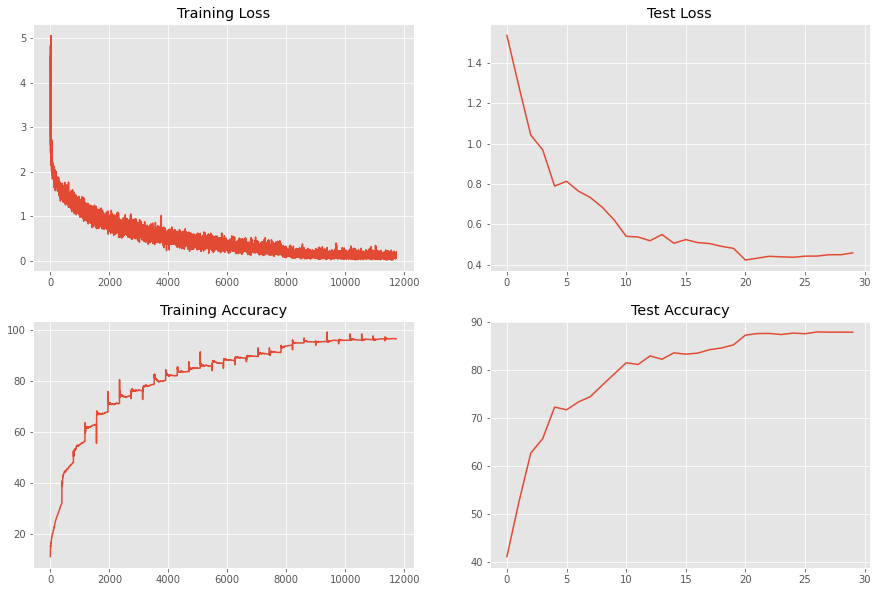

In [11]:
utils.valid_accuracy_loss_plots(train_losses, train_acc, test_losses, test_acc)

## Display misclassified images

In [12]:
images, act_lbl, pred_lbl = utils.get_images_by_results(model,test_loader,number_of_images = 25, mode= 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

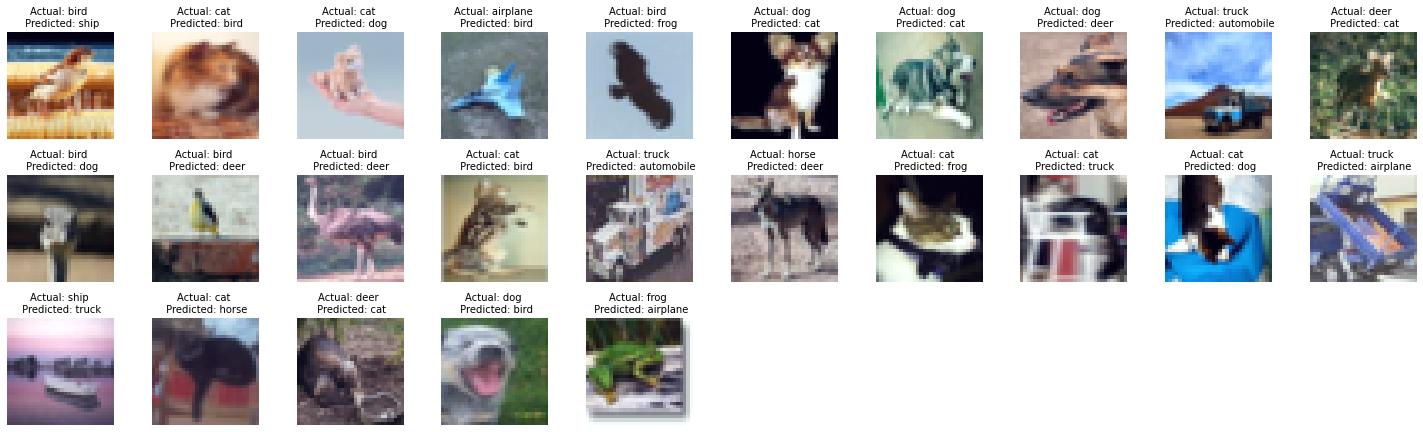

In [13]:
utils.show_images(images, act_lbl, pred_lbl, classes, num_of_images = 25)

# Grad Cam Implementation

In [14]:
model = model.to('cuda')

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


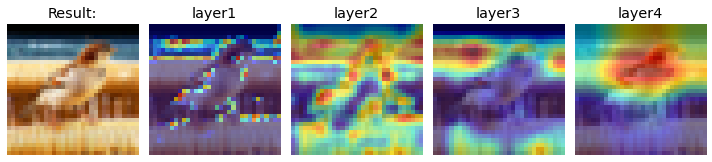

<Figure size 432x288 with 0 Axes>

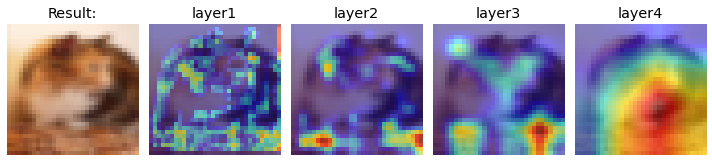

<Figure size 432x288 with 0 Axes>

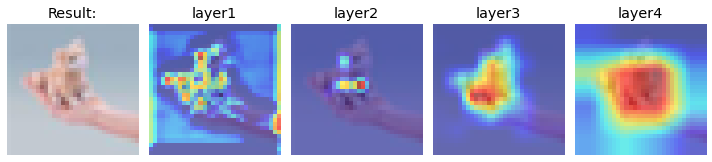

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

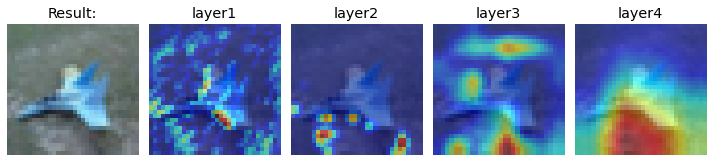

<Figure size 432x288 with 0 Axes>

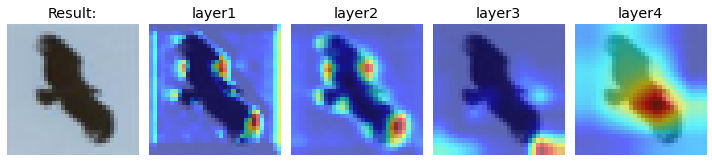

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

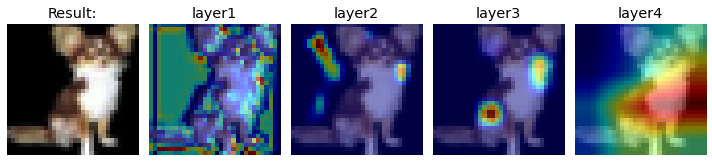

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

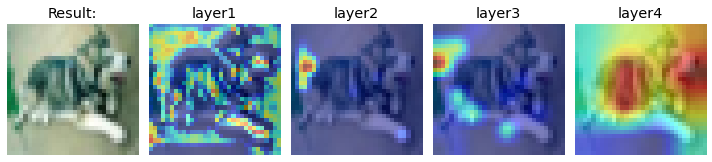

<Figure size 432x288 with 0 Axes>

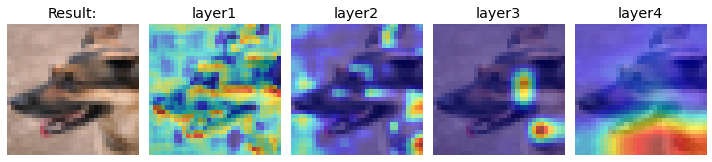

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

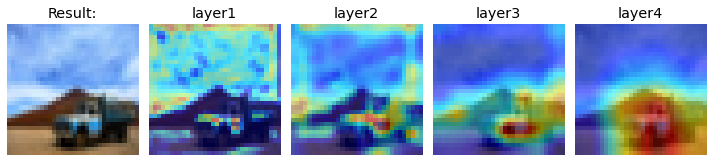

<Figure size 432x288 with 0 Axes>

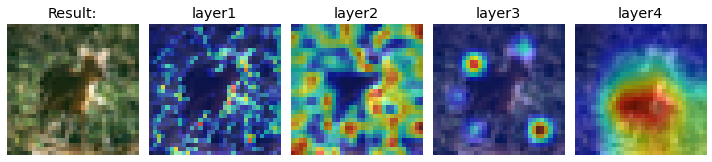

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

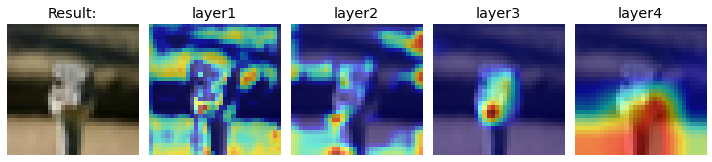

<Figure size 432x288 with 0 Axes>

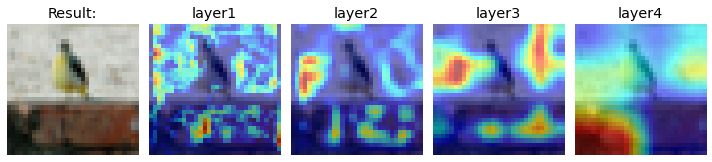

<Figure size 432x288 with 0 Axes>

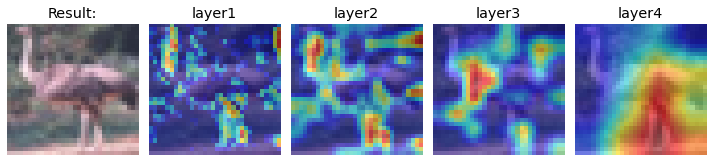

<Figure size 432x288 with 0 Axes>

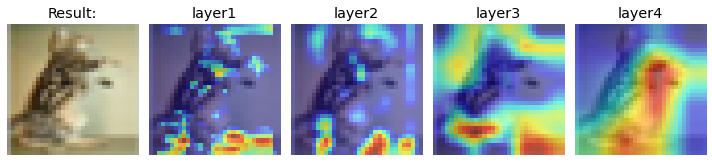

<Figure size 432x288 with 0 Axes>

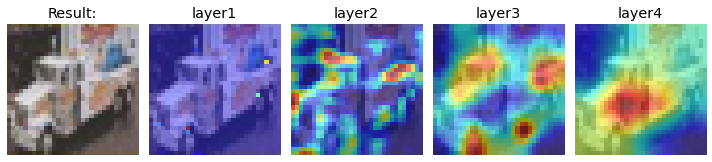

<Figure size 432x288 with 0 Axes>

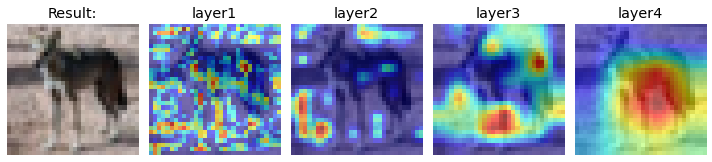

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

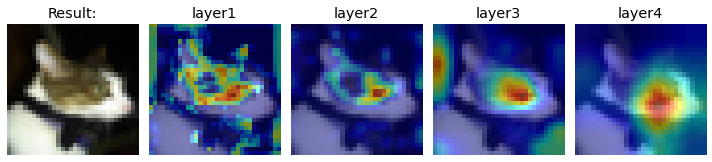

<Figure size 432x288 with 0 Axes>

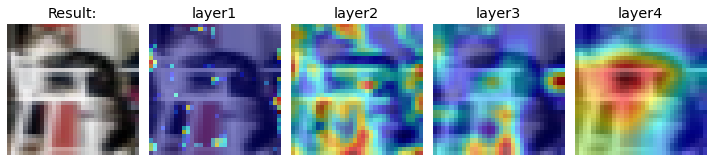

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

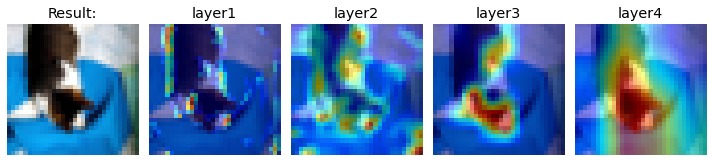

<Figure size 432x288 with 0 Axes>

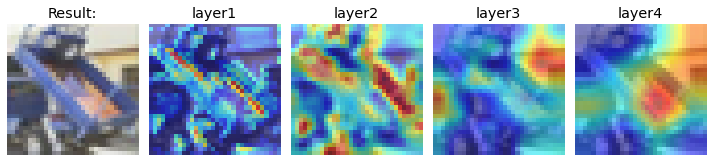

<Figure size 432x288 with 0 Axes>

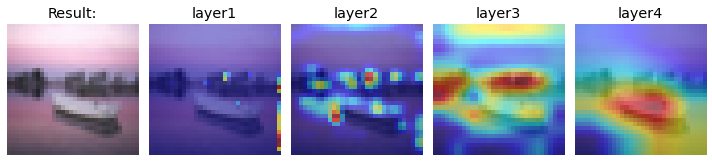

<Figure size 432x288 with 0 Axes>

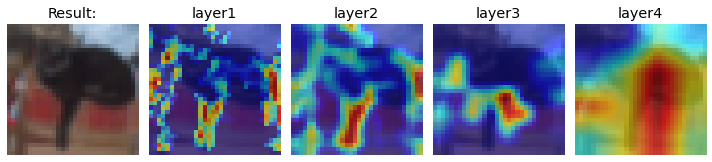

<Figure size 432x288 with 0 Axes>

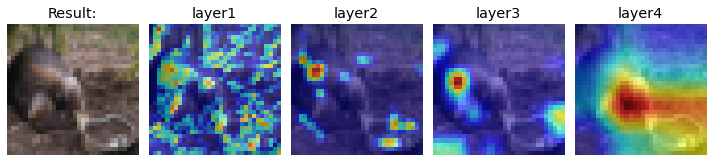

<Figure size 432x288 with 0 Axes>

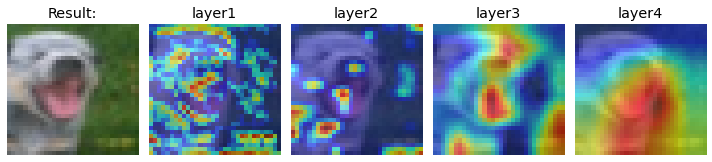

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

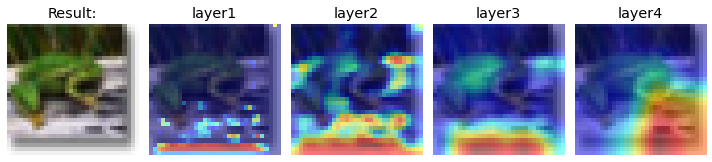

<Figure size 432x288 with 0 Axes>

In [15]:
grad_cam = grad_cam.GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, norm_mean,norm_std 
)

# Show grad cam for above mentioned miss classified images 
grad_cam(images, 'grad_cam')